In [1]:
!pip install pandas numpy matplotlib statsmodels

In [2]:
!pip install pmdarima darts tbats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 20.5 MB/s eta 0:00:

## Download Data

In [3]:
# https://drive.google.com/file/d/1k2qILdyzADkZBH78bYfiuLqy3sqVLFCB/view?usp=drive_link
!gdown 1k2qILdyzADkZBH78bYfiuLqy3sqVLFCB

Downloading...
From: https://drive.google.com/uc?id=1k2qILdyzADkZBH78bYfiuLqy3sqVLFCB
To: /content/sales_data.csv
100% 23.9k/23.9k [00:00<00:00, 18.1MB/s]


## Dataset

In this exercise, we're using ticket sales data collected between January 2015 and April 2017. Over time, as there's more demand for tickets, new venues have been added thus increasing total capacity.

The `sales_data.csv` file has four columns: `date`, `sold` (number of tickets), `capacity`, and `revenue` ($). We'll be focusing on the number of tickets sold (column `sold`) only.

Load the data into a Pandas dataframe and set the date as index.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv('sales_data.csv')
df.set_index('date', inplace=True)
df

,sold,capacity,revenue
date,,,
2015-01-01,554,984,5037.0
2015-01-02,695,984,6293.0
2015-01-03,585,984,5265.0
2015-01-04,491,984,4419.0
2015-01-05,449,984,4041.0
...,...,...,...
2017-04-26,900,1640,11045.0
2017-04-27,1076,1804,13473.0
2017-04-28,1828,3034,24353.0


Then, plot the data. Do you see any distinguishable patterns? Does it seem to have a trend over time?

<Axes: xlabel='date'>

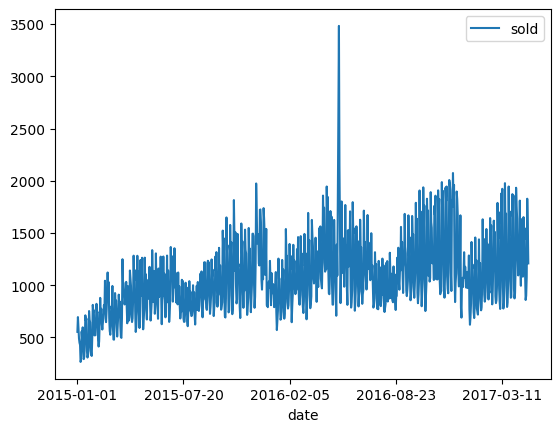

In [5]:
sales = df[['sold']]
sales.plot()

# Part #0

## Stationarity

In order to check if there's a trend or not, we need to check the series' stationarity. We'll use the Augmented Dick-Fuller's Test (the function is reproduced below for your convenience).

Hint: you can model a linear trend (if there's one) by adding `t` to the `regression` argument.

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, regression='c'):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC", regression=regression)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [7]:
adf_test(sales.values)

Results of Dickey-Fuller Test:
Test Statistic                  -3.131253
p-value                          0.024325
#Lags Used                      21.000000
Number of Observations Used    829.000000
Critical Value (1%)             -3.438263
Critical Value (5%)             -2.865033
Critical Value (10%)            -2.568630
dtype: float64


Is there a trend?

## Seasonality

Now, we need to check if the series shows signs of seasonality. We may use the partial autocorrelation function (PACF) plot to investigate this.

Hint: recurring spikes as every `t` steps are a sign of a seasonality (`t` periods)

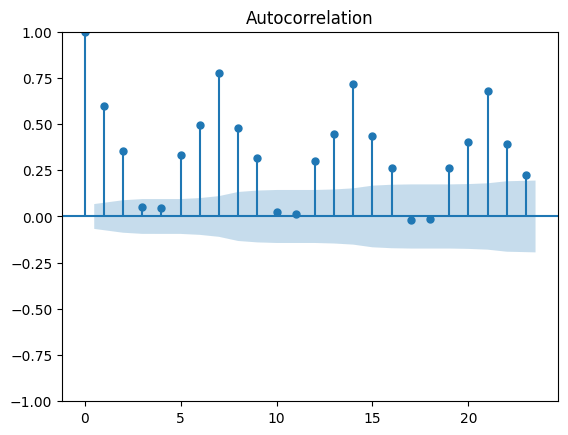

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sales.values, lags=23);

Is there seasonality in the series?

## ARIMA

Let's try an ARIMA model but, first, let's save the last 28 days as our test set.

In [9]:
from pmdarima import model_selection

train, test = model_selection.train_test_split(sales, train_size=len(sales)-28)

The ADF test implemented in `pmdarima` should give us the same result as before and, on top of that, it tell us straight away if we should differentiate the series or not.

In [10]:
from pmdarima.arima import ADFTest

ADFTest().should_diff(train)

(0.01, False)

In order to steer the choice of the appropriate ARIMA model, we need to provide the function with the information about the need (or not) to differentiate the time series (arguments `d` and `D`, the latter for the seasonal component, if any) and if there's seasonality (`seasonal` may be true or false, and `m` specifies the number of periods in the seasonality, as you have determined above).

In [11]:
import pmdarima as pm

d = 0
D = 0
seasonal = True
m = 7

# Fit a simple auto_arima model
arima = pm.auto_arima(train, error_action='ignore', trace=True, suppress_warnings=True, maxiter=5,
                      d=d, D=D, seasonal=seasonal, m=m)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=15706.253, Time=4.17 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=12031.986, Time=0.27 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=11373.681, Time=2.20 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=11534.052, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13896.594, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=11666.611, Time=0.42 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=13778.808, Time=2.86 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=16844.767, Time=1.08 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=11384.029, Time=0.93 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=14350.620, Time=1.93 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=11982.759, Time=0.83 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=5.90 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=12205.040, Time=0.86 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=12098.087, Time=1.02 sec
 ARIMA(2,0,1)(1,0,0)[7] i

Now, let's plot the model's fitted values.

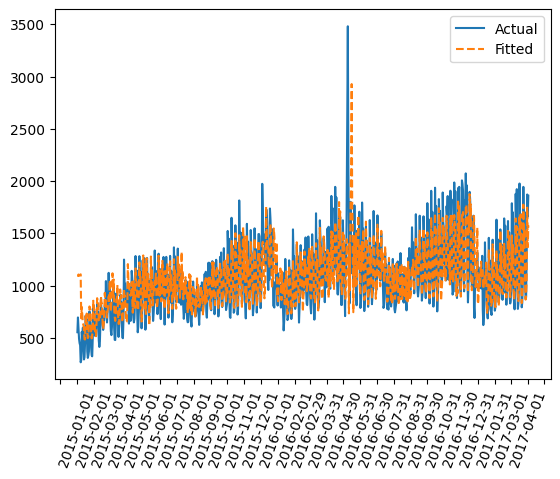

In [12]:
fig, ax = plt.subplots(1, 1)
ax.plot(train.index, train, label='Actual')
ax.plot(train.index, arima.fittedvalues(), label='Fitted', linestyle='--')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
plt.legend()

Does it look good? Do you see anything peculiar?

Then, let's try a scatter plot to compare actual and forecast values.

Text(0, 0.5, 'Forecast')

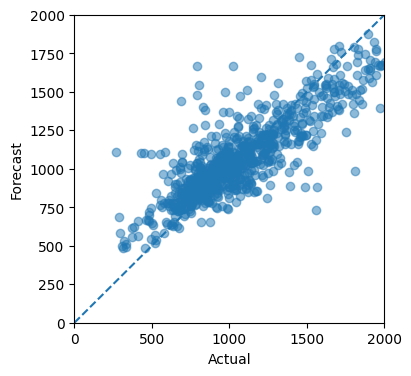

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(train, arima.fittedvalues(), alpha=0.5)
ax.plot([0, 2000], [0, 2000], linestyle='--')
ax.set_xlim([0, 2000])
ax.set_xlabel('Actual')
ax.set_ylim([0, 2000])
ax.set_ylabel('Forecast')

Does it match your expectations, after you've seen the previous plot?

Next, let's get some actual metrics for our model, namely, MAPE and sMAPE.

In [14]:
def mape(y_true, y_pred):
    actual = y_true.copy()
    forecast = y_pred.copy()
    if isinstance(actual, (pd.Series, pd.DataFrame)):
        actual = actual.values
    if isinstance(forecast, (pd.Series, pd.DataFrame)):
        forecast = forecast.values
    if isinstance(actual, np.ndarray):
        actual = actual.squeeze()
    if isinstance(forecast, np.ndarray):
        forecast = forecast.squeeze()

    # Ensure the arrays have the same length
    assert len(actual) == len(forecast), "Length of actual and forecast arrays should be the same"

    # Avoid division by zero by replacing zeros in the 'actual' array with a small number
    actual = np.where(actual == 0, 1e-10, actual)

    # Calculate MAPE for each data point
    mape_values = np.abs((actual - forecast) / actual)

    # Calculate the mean MAPE value
    mean_mape = np.mean(mape_values) * 100  # Multiply by 100 to get percentage

    return mean_mape

def smape(y_true, y_pred):
    actual = y_true.copy()
    forecast = y_pred.copy()
    if isinstance(actual, (pd.Series, pd.DataFrame)):
        actual = actual.values
    if isinstance(forecast, (pd.Series, pd.DataFrame)):
        forecast = forecast.values
    if isinstance(actual, np.ndarray):
        actual = actual.squeeze()
    if isinstance(forecast, np.ndarray):
        forecast = forecast.squeeze()

    # Ensure the arrays have the same length
    assert len(actual) == len(forecast), "Length of actual and forecast arrays should be the same"

    # Calculate SMAPE for each data point
    smape_values = 2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast))

    # Calculate the mean SMAPE value
    mean_smape = np.mean(smape_values) * 100  # Multiply by 100 to get percentage

    return mean_smape

In [15]:
mape(train, arima.fittedvalues()),smape(train, arima.fittedvalues())

(15.465139160638994, 14.057681128796112)

Now, let's make a forecast for the 28 days in the future (our test set).

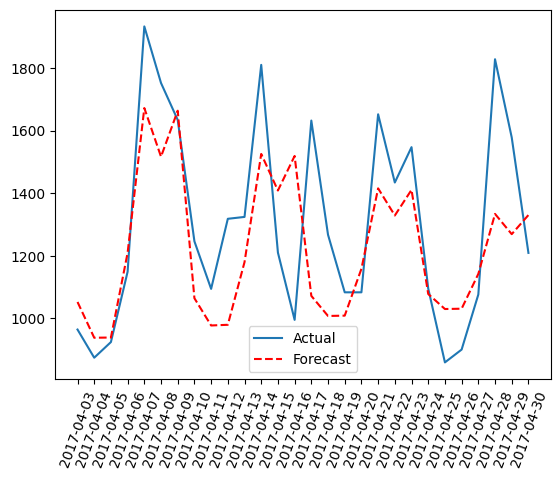

In [16]:
x = np.arange(test.shape[0])
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima.predict(n_periods=len(x)), label='Forecast', linestyle='--', c='r')
plt.xticks(rotation=70)
plt.legend()

Is it good? What happens over time? Can you guess why?

# Part #1

## Simple Exponential Smoothing (SES)

Next, let's try a basic SES model but, instead of trying to guess the smoothing and initial levels, we'll let the model estimate the initial level and optimize the smoothing level.

In [17]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(train, initialization_method='estimated').fit(optimized=True)
ses.params

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.09530264002448346,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 502.47864377736437,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Which smoothing level did we get? Will it track the actual data closely or loosely? Why?

After you answered these questions, plot the fitted values to find out.

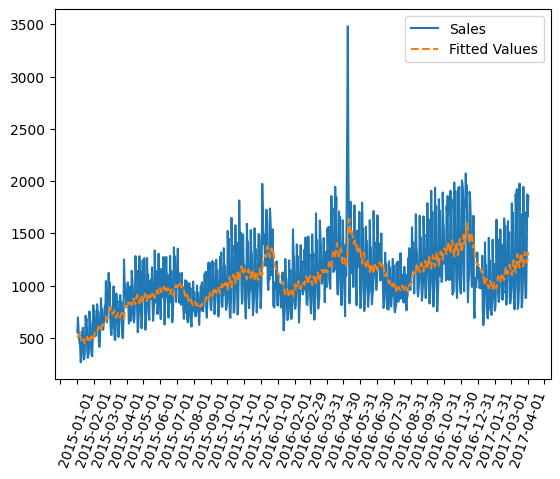

In [18]:
fig, ax = plt.subplots(1, 1)
ax.plot(train.index, train, label='Sales')
ax.plot(train.index, ses.fittedvalues, linestyle='--', label='Fitted Values')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
ax.legend()

Did it match your expectations?

If we try the scatter plot once again, do you think it will be better or worse than the previous one? Why?

Text(0, 0.5, 'Forecast')

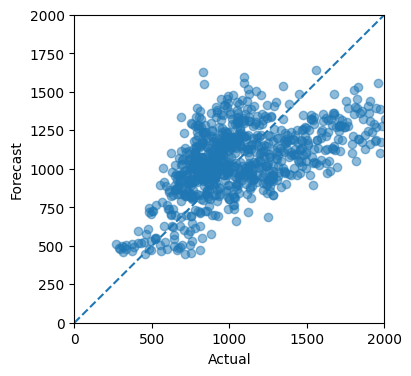

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(train, ses.fittedvalues, alpha=0.5)
ax.plot([0, 2000], [0, 2000], linestyle='--')
ax.set_xlim([0, 2000])
ax.set_xlabel('Actual')
ax.set_ylim([0, 2000])
ax.set_ylabel('Forecast')

Did you get it right?

Let's compute MAPE and sMAPE once again:

In [20]:
mape(train, ses.fittedvalues), smape(train, ses.fittedvalues),

(23.163001637580283, 22.29040646929616)

Now, consider the 28-day forecast, how would it look like for a SES model? Once you answered it, run the plot below.

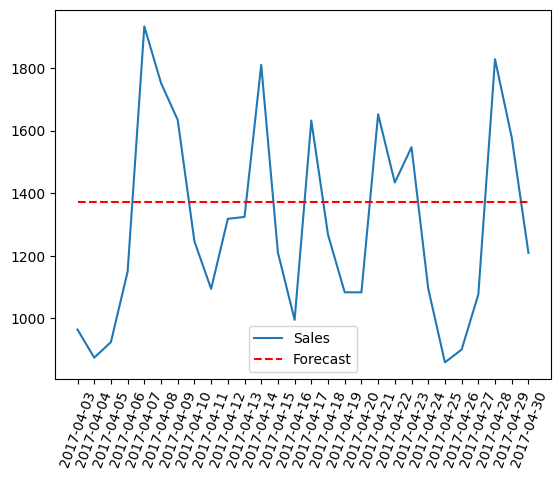

In [21]:
plt.plot(test.index, test, label='Sales')
plt.plot(test.index, ses.forecast(28), linestyle='--', c='r', label='Forecast')
plt.xticks(rotation=70)
plt.legend()

Did it match your expecations?

### Probabilistic Forecasting

Exponential smoothing models are interesting because they allow us to reframe them as probabilistic (ETS) models. Let's run the very same model as above probabilistic-style!

In [22]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

model = ETSModel(train.squeeze(), initialization_method='estimated')
fit = model.fit(optimized=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(


Now, forecast the values for the next 28 days, from 2017-04-03 to 2017-04-30:

In [23]:
pred = fit.get_prediction(start="2017-04-03", end="2017-04-30")
pred

What do you expect the following cell to produce?

In [24]:
pred.predicted_mean

,0
2017-04-03,1371.948687
2017-04-04,1371.948687
2017-04-05,1371.948687
2017-04-06,1371.948687
2017-04-07,1371.948687
2017-04-08,1371.948687
2017-04-09,1371.948687
2017-04-10,1371.948687
2017-04-11,1371.948687
2017-04-12,1371.948687


Let's make it more interesting now and produce some confidence intervals for the prediction (choose an `alpha` level) using the `summary_frame()` method:

In [25]:
alpha = 0.05
df = pred.summary_frame(alpha=alpha)
df

,mean,pi_lower,pi_upper
2017-04-03,1371.948687,783.324803,1960.572571
2017-04-04,1371.948687,780.626580,1963.270793
2017-04-05,1371.948687,777.940614,1965.956759
2017-04-06,1371.948687,775.266739,1968.630634
2017-04-07,1371.948687,772.604793,1971.292581
2017-04-08,1371.948687,769.954618,1973.942756
2017-04-09,1371.948687,767.316058,1976.581316
2017-04-10,1371.948687,764.688963,1979.208411
2017-04-11,1371.948687,762.073184,1981.824190
2017-04-12,1371.948687,759.468577,1984.428797


Now, use the `simulate()` method to generate multiple forecast scenarios (`repetitions` arg) for a given time period `nsimulations` arg):

In [26]:
simulated = fit.simulate(anchor="end", nsimulations=28, repetitions=100)
simulated

,simulation.0,simulation.1,simulation.2,simulation.3,simulation.4,simulation.5,simulation.6,simulation.7,simulation.8,simulation.9,...,simulation.90,simulation.91,simulation.92,simulation.93,simulation.94,simulation.95,simulation.96,simulation.97,simulation.98,simulation.99
2017-04-03,903.238787,1398.020091,894.122862,1513.037257,1222.582197,1284.369404,1278.444695,808.024986,1736.089344,1786.871725,...,903.630713,1593.756034,1555.260102,1495.093358,1178.717224,1347.014051,1097.535167,1761.320224,1622.237367,748.332820
2017-04-04,1009.232385,1447.001800,1001.863502,1954.092787,889.488235,1136.511822,1680.413620,1341.450095,1849.052642,1556.287775,...,1024.938354,1023.911516,1451.731417,1408.417637,1235.261837,1217.565948,1205.684786,1087.525241,1751.310201,1071.578555
2017-04-05,1462.557800,1476.048446,1422.892182,1865.045594,1523.456605,1040.615546,1414.526090,1457.503851,1064.201845,1327.139752,...,1257.797384,1521.479142,1264.410837,1608.317239,1403.187459,1430.362226,1365.539472,1118.362733,1384.599392,1236.667019
2017-04-06,1173.345398,1532.887860,1927.761910,1286.945064,950.893186,1664.250728,1434.213433,1591.152437,1494.271848,1531.810276,...,1513.949101,2073.417457,1114.056325,1151.511864,1330.131244,1404.634192,1642.585623,1315.461830,1187.131312,1095.247881
2017-04-07,1226.015600,1555.409481,1483.749876,1725.261611,1484.822511,1665.410127,1404.626583,1357.197657,1703.018195,1445.793599,...,1162.321050,1242.784680,1410.885329,1165.503961,1713.237747,1168.137176,1390.205636,1358.755621,1364.132126,1128.219756
2017-04-08,1326.254567,632.254575,991.921939,1413.111766,1521.056936,1196.633944,1049.805255,1360.241184,1207.748757,1410.844427,...,705.425949,1233.192337,1509.891148,1276.512405,1142.162610,1387.067441,1963.248145,1061.385997,1637.020761,1719.742179
2017-04-09,1011.208361,1286.350068,1337.713979,1409.183455,1299.096186,1469.935681,1887.793663,1244.909801,1443.284049,1314.979468,...,1033.381698,1002.217021,1278.462944,1739.627758,2070.238308,1102.689922,1773.797885,1788.566221,1440.299058,1383.931761
2017-04-10,1336.680003,1756.514447,1430.198212,1292.381906,1227.048680,1325.514149,1309.899621,1133.872912,1345.029301,2061.068601,...,1242.181858,1444.539610,1545.235937,1105.384257,1105.387495,1401.849679,1022.275439,1434.785924,1634.830262,1478.987855
2017-04-11,1009.775335,1751.956809,1511.866023,1419.107002,855.956074,844.568713,1610.347946,1053.772569,893.909949,1835.880833,...,1482.658352,1307.027129,2088.735728,1546.430798,1112.762583,1073.116111,1659.151949,1591.317491,893.795930,961.622775
2017-04-12,1582.805596,1646.946530,1678.604244,1523.551839,1517.493107,1428.180748,950.106335,1206.111726,1654.925049,1230.620311,...,1345.110665,1066.129354,1735.240217,1746.990632,1479.351125,1272.210930,1446.376097,1123.098503,1188.773417,1539.861764


The plot below puts everything together, simulations and confidence intervals:

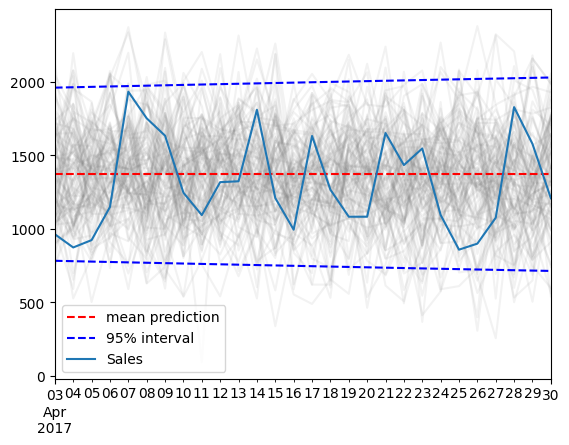

In [27]:
for i in range(simulated.shape[1]):
    simulated.iloc[:, i].plot(label="_", color="gray", alpha=0.1)

df["mean"].plot(label="mean prediction", linestyle='--', c='r')
df["pi_lower"].plot(linestyle="--", c='b', label="95% interval")
df["pi_upper"].plot(linestyle="--", c='b', label="_")
plt.plot(df.index, test, label='Sales')
plt.legend()

## Holt-Winters

It is time to use a better model like Triple Exponential Smoothing (Holt-Winters). In this model, we can specify both trend and seasonal components:
- seasonality through `seasonal` (`add`, `mul`, or `None`) and `seasonal_periods` arguments
- trend through `trend` (`add`, `mul`, or `None`) argument
As before, we can have the model estimate the initial level and optimize the smoothing level.

In [28]:
from statsmodels.tsa.api import ExponentialSmoothing

seasonal_periods = 7

holt_winters = ExponentialSmoothing(
    train.squeeze(),
    seasonal_periods=seasonal_periods,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
).fit(optimized=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Let's visualize the actual and fitted values, both as line and scatter plots:

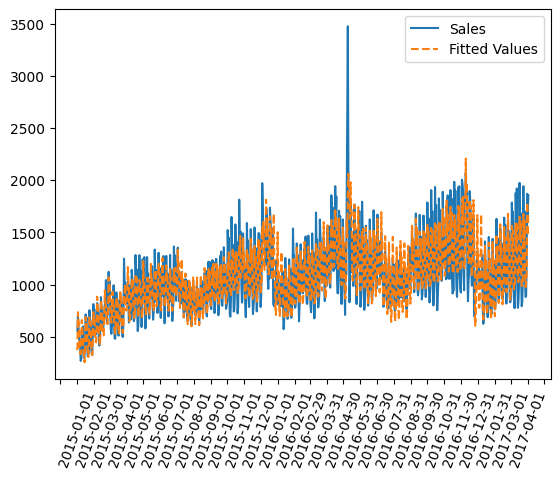

In [29]:
fig, ax = plt.subplots(1, 1)
ax.plot(train.index, train, label='Sales')
ax.plot(train.index, holt_winters.fittedvalues, linestyle='--', label='Fitted Values')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
ax.legend()

Text(0, 0.5, 'Forecast')

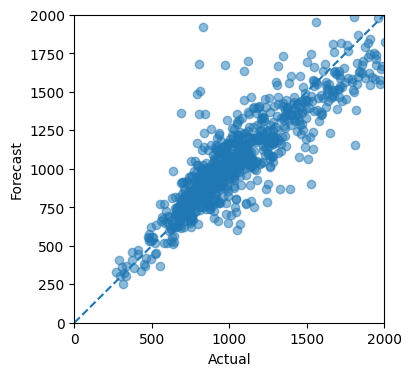

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(train, holt_winters.fittedvalues, alpha=0.5)
ax.plot([0, 2000], [0, 2000], linestyle='--')
ax.set_xlim([0, 2000])
ax.set_xlabel('Actual')
ax.set_ylim([0, 2000])
ax.set_ylabel('Forecast')

How does this model compare to the first ARIMA model we fitted?

Compute both MAPE and sMAPE metrics to get a more definitive answer.

In [31]:
mape(train, holt_winters.fittedvalues), smape(train, holt_winters.fittedvalues)

(11.697507162827204, 11.366589401096604)

Now, make a forecast for 28 days ahead and compare to the actual data:

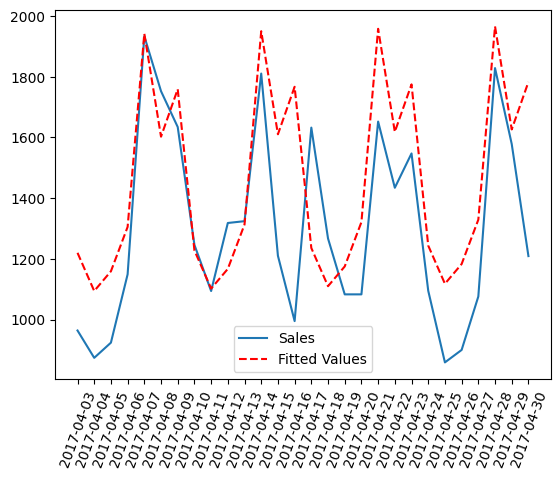

In [32]:
fc_values = holt_winters.forecast(28)

plt.plot(test.index, test, label='Sales')
plt.plot(test.index, fc_values, linestyle='--', c='r', label='Fitted Values')
plt.xticks(rotation=70)
plt.legend()

How is this forecast different than the previous ones (e.g. patterns, evolution over time)?

Let's make it more interesting by fitting a probabilistic model. We're still using the `ETSModel` class, but we can add the same arguments we've already used to fit the Holt-Winters models above.

In [33]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

seasonal_periods = 7

model = ETSModel(
    train.squeeze(),
    seasonal_periods=seasonal_periods,
    trend="add",
    seasonal="add",
    initialization_method="estimated"
)
fit = model.fit(optimized=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(


Make predictions for the period starting on 2017-04-03 and ending on 2017-04-30 and plot the predicted mean against actual sales.

In [34]:
pred = fit.get_prediction(start="2017-04-03", end="2017-04-30")

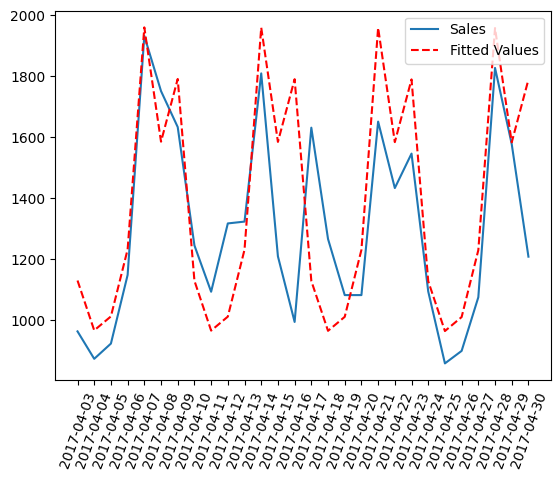

In [35]:
fit_vals = pred.predicted_mean

plt.plot(test.index, test, label='Sales')
plt.plot(test.index, fit_vals, linestyle='--', c='r', label='Fitted Values')
plt.xticks(rotation=70)
plt.legend()

### Probabilistic Forecasting

Now, compute confidence intervals using the `summary_frame()` method once again. Next, simulate forecast scenarios for 28 days ahead using `simulate()` method once again.

In [36]:
df = pred.summary_frame(alpha=0.05)
simulated = fit.simulate(anchor="end", nsimulations=28, repetitions=100)

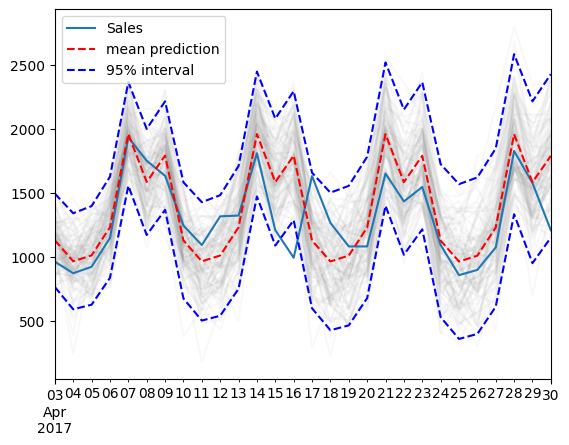

In [37]:
for i in range(simulated.shape[1]):
    simulated.iloc[:, i].plot(label="_", color="gray", alpha=0.05)

plt.plot(df.index, test, label='Sales')
df["mean"].plot(label="mean prediction", linestyle='--', c='r')
df["pi_lower"].plot(linestyle="--", color="b", label="95% interval")
df["pi_upper"].plot(linestyle="--", color="b", label="_")
plt.legend()

# Part #2

## Seasonal Decomposition

Decompose the training set into its trend, seasonal, and residual components using statsmodels' `seasonal_decompose`:

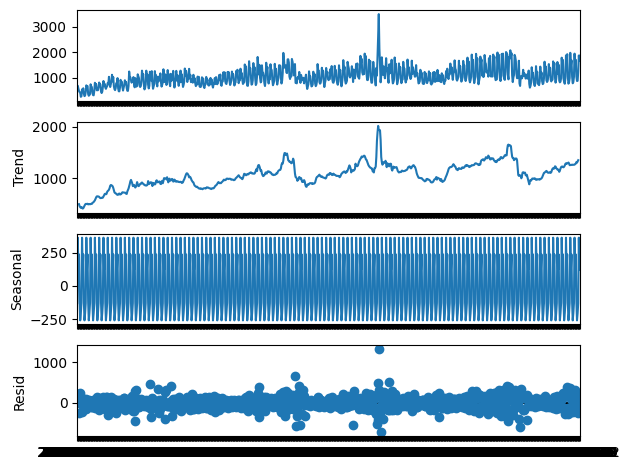

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train, model='additive', period=7)
result.plot();

In [39]:
df = pd.concat([result.trend, result.seasonal, result.resid], axis=1).tail(20)
df

,trend,seasonal,resid
date,,,
2017-03-14,1306.285714,-259.398460,-269.887254
2017-03-15,1288.571429,-206.299559,-253.271870
2017-03-16,1254.714286,-130.253161,-126.461125
2017-03-17,1256.285714,361.387075,359.327210
2017-03-18,1258.428571,120.624760,90.946668
2017-03-19,1259.571429,236.011796,190.416775
2017-03-20,1265.285714,-122.072453,-86.213262
2017-03-21,1260.714286,-259.398460,-209.315826
2017-03-22,1261.857143,-206.299559,-218.557584


What's happening at the end of the training period? Why?

Compute the strength of both trend and seasonal components. Did you expect the results?

In [40]:
# Trend
strength_trend = max(0, 1-df['resid'].var()/(df['resid']+df['trend']).var())

# Season
strength_season = max(0, 1-df['resid'].var()/(df['resid']+df['seasonal']).var())

strength_trend, strength_season

(0, 0.7681561501336347)

## STL Decomposition

Now, use STL decomposition instead. Remember that `period` represnts the seasonality period while `seasonal` (as confusing as it may be) represents **how many seasons** should be used to smoothen the seasonality using LOESS.

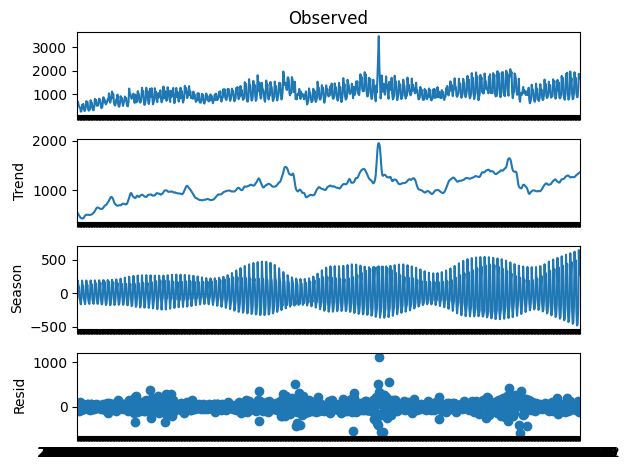

In [41]:
from statsmodels.tsa.seasonal import STL

stl = STL(train, period=7, seasonal=15)
res = stl.fit()
res.plot();

Look at the seasonal component of the plot above. How is it different than traditional seasonal decomposition? Why is that?

In [42]:
df = pd.concat([res.trend, res.seasonal, res.resid], axis=1).tail(20)
df

,trend,season,resid
date,,,
2017-03-14,1294.081203,-429.122449,-87.958755
2017-03-15,1280.980189,-401.897514,-50.082675
2017-03-16,1265.779081,-187.148658,-80.630424
2017-03-17,1257.126587,600.188203,119.685209
2017-03-18,1258.194364,226.128908,-14.323272
2017-03-19,1262.334384,469.581073,-45.915457
2017-03-20,1265.104888,-251.163227,43.058339
2017-03-21,1264.284563,-455.031389,-17.253174
2017-03-22,1260.831226,-428.819077,4.987851


Compute the strength of both trend and seasonal components:

In [43]:
# Trend
strength_trend = max(0, 1-df['resid'].var()/(df['resid']+df['trend']).var())

# Season
strength_season = max(0, 1-df['resid'].var()/(df['resid']+df['season']).var())

strength_trend, strength_season

(0.2310901506888926, 0.9772109827824703)

Now, use `STLForecast` to model and forecast seasonality while using an exponential smoothing model to forecast both level and trend (if any):

In [44]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.statespace import exponential_smoothing

index = pd.date_range(train.index[0], periods=len(train), freq='D')
train.index = index

ES = exponential_smoothing.ExponentialSmoothing
config = {"trend": False, "initialization_method": "estimated"}
period = 7
s_window = 15

stlf = STLForecast(train, ES, model_kwargs=config, period=period, seasonal=s_window)
resf = stlf.fit()
forecasts = resf.forecast(28)

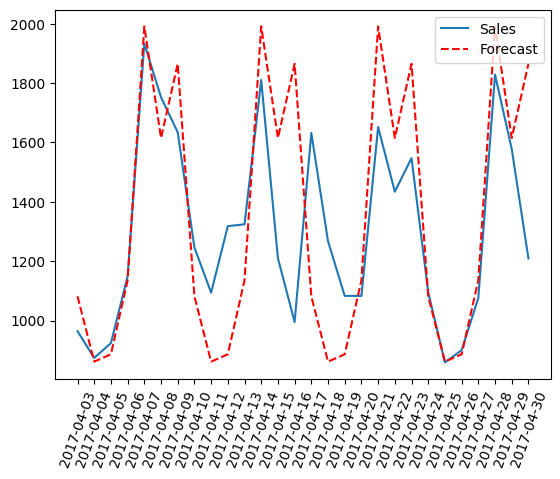

In [45]:
plt.plot(test.index, test, label='Sales')
plt.plot(test.index, forecasts, label='Forecast', c='r', linestyle='--')
plt.xticks(rotation=70)
plt.legend()

How is this forecast different from that produced by the Holt-Winters method? Why?

# Part #3

## Feature Engineering

It is time to do some feature engineering. We'll create deterministic features out of the date components.

### Date Components

The index is being recreated as a proper date index to allow you to easily extract date components such as `day`, `month`, `weekday`, `weekofyear`, etc.

Given the seasonality of our time series, which components would you choose? For each chosen component, create a corresponding column in the `train` dataframe.

Hint: `weekofyear` was deprecated in favor of `isocalendar().week.astype(int)`

In [5]:
index = pd.date_range('2015-01-01', periods=823, freq='D')
train.index = index

train['woy'] = train.index.isocalendar().week.astype(int)
train['wday'] = train.index.weekday
train['t'] = pd.RangeIndex(len(train))

NameError: name 'pd' is not defined

Now, use an R-style formula to describe how sold tickets (`sold`) can be expressed in terms of the chosen components. Remember that categorical features must be wrapped with a `C()` function in the formula.

In [47]:
import statsmodels.formula.api as smf

# https://www.statsmodels.org/stable/example_formulas.html
mod_dummy = smf.ols("sold ~ t + C(woy) + C(wday)", data=train).fit()
mod_dummy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   sold   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     35.57
Date:                Tue, 01 Oct 2024   Prob (F-statistic):          9.83e-180
Time:                        14:54:08   Log-Likelihood:                -5470.1
No. Observations:                 823   AIC:                         1.106e+04
Df Residuals:                     763   BIC:                         1.134e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      471.6632     50.377      9.363      0.000     372.769     570.558
C(woy)[T.2]    -94.0781     62.196     -1.513      0.131    -216.173      28.017
C(woy)[T.3]    -55.5583     62.191     -0.893      0.372    -177.643      66.527
C(woy)[T.4]    -28.1813     62.186     -0.453      0.651    -150.258      93.895
C(woy)[T.5]     33.5289     62.183      0.539      0.590     -88.540     155.598
C(woy)[T.6]     47.1916     62.180      0.759      0.448     -74.872     169.255
C(woy)[T.7]     96.8543     62.177      1.558      0.120     -25.205     218.913
C(woy)[T.8]    118.4217     62.176      1.905      0.057      -3.634     240.477
C(woy)[T.9]    160.4177     62.175      2.580      0.010      38.364     282.472
C(woy)[T.10]   147.0327     62.175      2.365      0.018      24.979     269.086
C(woy)[T.11]   129.1716     62.175      2.078      0.038       7.117     251.226
C(woy)[T.12]   137.3104     62.176      2.208      0.028      15.254     259.367
C(woy)[T.13]   243.7826     62.178      3.921      0.000     121.722     365.843
C(woy)[T.14]   319.3120     69.124      4.619      0.000     183.617     455.007
C(woy)[T.15]   395.8080     69.110      5.727      0.000     260.139     531.477
C(woy)[T.16]   291.8754     69.098      4.224      0.000     156.232     427.519
C(woy)[T.17]   201.2285     69.085      2.913      0.004      65.608     336.849
C(woy)[T.18]   516.6531     69.074      7.480      0.000     381.055     652.251
C(woy)[T.19]   343.7920     69.063      4.978      0.000     208.216     479.368
C(woy)[T.20]   324.5022     69.053      4.699      0.000     188.946     460.059
C(woy)[T.21]   275.1411     69.043      3.985      0.000     139.604     410.679
C(woy)[T.22]   291.7085     69.034      4.226      0.000     156.189     427.228
C(woy)[T.23]   225.1331     69.026      3.262      0.001      89.630     360.637
C(woy)[T.24]   210.2005     69.018      3.046      0.002      74.712     345.689
C(woy)[T.25]   212.9822     69.011      3.086      0.002      77.508     348.456
C(woy)[T.26]   247.0496     69.005      3.580      0.000     111.588     382.511
C(woy)[T.27]   281.6171     68.999      4.081      0.000     146.167     417.067
C(woy)[T.28]   118.8273     68.993      1.722      0.085     -16.612     254.267
C(woy)[T.29]    43.7519     68.989      0.634      0.526     -91.679     179.182
C(woy)[T.30]    28.9622     68.985      0.420      0.675    -106.460     164.385
C(woy)[T.31]    -0.7561     68.981     -0.011      0.991    -136.172     134.660
C(woy)[T.32]    20.9542     68.979      0.304      0.761    -114.456     156.365
C(woy)[T.33]    28.6645     68.976      0.416      0.678    -106.742     164.071
C(woy)[T.34]    91.0176     68.975      1.320      0.187     -44.386     226.421
C(woy)[T.35]   193.6564     68.974      2.808      0.005      58.255     329.058
C(woy

Use the model to make predictions using the dummy variables you created:

In [48]:
pred = mod_dummy.predict(train[['t', 'woy', 'wday']])
pred

,0
2015-01-01,466.627205
2015-01-02,957.381442
2015-01-03,718.508561
2015-01-04,835.635679
2015-01-05,380.281312
...,...
2017-03-29,1183.985126
2017-03-30,1262.449851
2017-03-31,1753.204088
2017-04-01,1514.331207


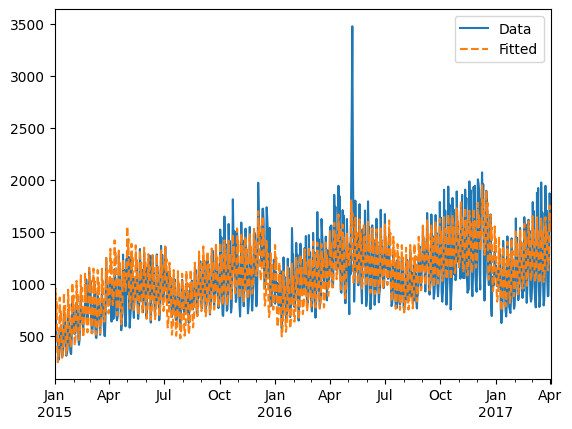

In [49]:
train['sold'].plot(label='Data')
pred.plot(label='Fitted', linestyle='--')
plt.legend()

How does it look like?

Compute both MAPE and sMAPE.

In [50]:
mape(train['sold'], pred), smape(train['sold'], pred)

(13.136037768462156, 12.785229080708923)

Now, make a forecast for the next 28 days. We'll need to recreate the index for the test set as well to re-create the same features we chose to extract in the training set.

In [66]:
index = pd.date_range('2017-04-03', periods=28, freq='D')
test.index = index
test['woy'] = test.index.isocalendar().week.astype(int)
test['wday'] = test.index.weekday
test['t'] = pd.RangeIndex(len(test))+len(train)

Use the model to make the forecast:

In [67]:
fcast = mod_dummy.predict(test[['t', 'woy', 'wday']])

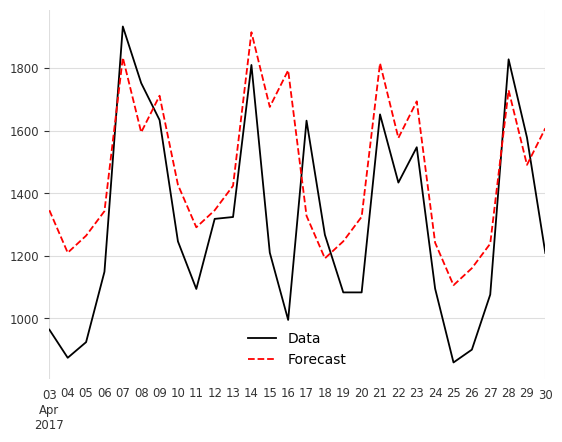

In [68]:
test['sold'].plot(label='Data')
fcast.plot(label='Forecast', linestyle='--', c='r')
plt.legend()

What does this forecast look like? Is it good or not? Why?

### Lags

Now, let's use DARTS to create a linear model that uses lags of the target variable itself as features. Although it's a simple linear regression, using DARTS saves us the trouble of having to loop through predictions to make forecast several periods ahead.

The `lags` argument takes a list of negative values corresponding to how many time steps in the past should be used as features. For example, `-1` indicates the value from yesterday (assuming daily frequency) should be used as feature to forecast today's value.

Create a model and choose one or more lags (consider the seasonality of the time series in your choice). DARTS requires the input to be a `TimeSeries` object, so we're creating one from a copy of our series.

In [54]:
from darts import TimeSeries
new_y = train['sold'].copy()
ts_y = TimeSeries.from_series(new_y)
ts_y

<TimeSeries (DataArray) (time: 823, component: 1, sample: 1)> Size: 7kB
array([[[ 554.]],

       [[ 695.]],

       [[ 585.]],

       [[ 491.]],

       [[ 449.]],

       [[ 429.]],

       [[ 266.]],

       [[ 286.]],

       [[ 557.]],

       [[ 482.]],

...

       [[1945.]],

       [[1478.]],

       [[1706.]],

       [[1054.]],

       [[ 880.]],

       [[ 888.]],

       [[1246.]],

       [[1872.]],

       [[1659.]],

       [[1860.]]])
Coordinates:
  * time       (time) datetime64[ns] 7kB 2015-01-01 2015-01-02 ... 2017-04-02
  * component  (component) object 8B 'sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [55]:
from darts.models import LinearRegressionModel

model = LinearRegressionModel(
    lags=[-1, -7, -28],
)

model.fit(ts_y)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


LinearRegressionModel(lags=[-1, -7, -28], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

You can inspect the corresponding coefficients by retrieving the underlying linear model (which is a Scikit-Learn model in this case):

In [56]:
model.model

LinearRegression()

In [57]:
model.model.coef_

array([0.21590765, 0.50811535, 0.23878634])

Use the model's `historical_forecasts()` method to obtain the fitted values:

In [58]:
fittedvals = model.historical_forecasts(ts_y)

<Axes: xlabel='time'>

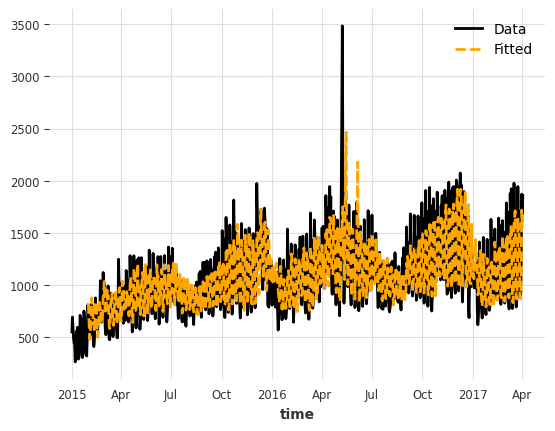

In [59]:
ts_y.plot(label='Data')
fittedvals.plot(label='Fitted', linestyle='--', c='orange')

Let's check both MAPE and sMAPE (since we're using lagged features, there are fewer fitted values than the number of original values):

In [2]:
mape(ts_y.values()[30:], fittedvals.values()), smape(ts_y.values()[30:], fittedvals.values())

NameError: name 'mape' is not defined

Now, use the model's `predict()` method to make a forecast for 28 days in the future.

In [61]:
fcast = model.predict(28)
fcast

<TimeSeries (DataArray) (time: 28, component: 1, sample: 1)> Size: 224B
array([[[1239.58772422]],

       [[ 976.041221  ]],

       [[ 901.84539617]],

       [[1110.29481261]],

       [[1672.46678548]],

       [[1637.15942765]],

       [[1801.89331733]],

       [[1336.63750377]],

       [[1033.5495885 ]],

       [[ 934.70349563]],

...

       [[1521.19945375]],

       [[1534.30052901]],

       [[1652.64699527]],

       [[1366.76713165]],

       [[1112.21348805]],

       [[ 997.060719  ]],

       [[1086.18702736]],

       [[1487.16758626]],

       [[1543.58479233]],

       [[1660.5875454 ]]])
Coordinates:
  * time       (time) datetime64[ns] 224B 2017-04-03 2017-04-04 ... 2017-04-30
  * component  (component) object 8B 'sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='time'>

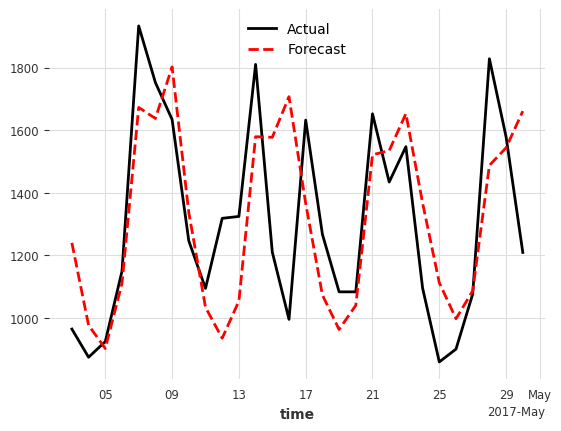

In [62]:
TimeSeries.from_series(test['sold']).plot(label='Actual')
fcast.plot(label='Forecast', c='r', linestyle='--')

Is this forecast better or worse than that produced by the model using date components? How is it different?

## ML Model

Now, let's use a ML model to combine both lagged features, date components, and yet another feature: holidays.

### Holidays

Holidays are important features whenever human behavior is part of the data generating process (e.g. sales, travel, etc.). In DARTS, we can retrieve holidays for countries and regions using the `holidays_timeseries()` function.

In [63]:
from darts.utils.timeseries_generation import holidays_timeseries

def get_holiday(idx):
    return holidays_timeseries(idx, country_code='DE')

Holidays, like other date components, are known **ahead of time**, so they are **future covariates**. To build the corresponding time series, so that we can use it in our ML model, we need to compute holiday features for the totality of dates (both in train and test sets).

In [69]:
future_cov = get_holiday(train.index.union(test.index))
future_cov

<TimeSeries (DataArray) (time: 851, component: 1, sample: 1)> Size: 7kB
array([[[1.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

...

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]]])
Coordinates:
  * time       (time) datetime64[ns] 7kB 2015-01-01 2015-01-02 ... 2017-04-30
  * component  (component) object 8B 'holidays'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Use DARTS `datetime_attribute_timeseries` to create more future covariates, such as month, day of the week, and week of the year. The time series object has a `stack()` method so you can stack them up on the `future_cov` variable used to retrieve the holidays.

In [70]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

time_index = train.index.union(test.index)

month = datetime_attribute_timeseries(time_index=time_index, attribute="month")
weekday = datetime_attribute_timeseries(time_index=time_index, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index=time_index, attribute="weekofyear")
future_cov = future_cov.stack(month).stack(weekday).stack(weekofyear)
future_cov = future_cov.astype(np.float32)
future_cov

<TimeSeries (DataArray) (time: 851, component: 4, sample: 1)> Size: 14kB
array([[[ 1.],
        [ 0.],
        [ 3.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 4.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 5.],
        [ 0.]],

       ...,

       [[ 0.],
        [ 3.],
        [ 4.],
        [16.]],

       [[ 0.],
        [ 3.],
        [ 5.],
        [16.]],

       [[ 0.],
        [ 3.],
        [ 6.],
        [16.]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 7kB 2015-01-01 2015-01-02 ... 2017-04-30
  * component  (component) object 32B 'holidays' 'month' ... 'weekofyear'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Now, create an instance of `RandomForest` model. You may provide the following arguments:
- `lags`: a list of **negative** values specifying the lags to be used as features
- `lags_future_covariates`: a list of **positive** values specifying the look-ahead for the future covariates, a value of 0 means it will use the value for the date being forecast
- `output_chunk_length`: how many steps ahead you'd like the model to predict (e.g. 1 for single-step or 7 for predicting 7 days ahead at once thus avoiding auto-regressing behavior inside this time period)

You also need to provide arguments that are specific to the chosen model (random forest), such as `n_estimators` (the number of trees), `max_depth`, and `criterion` (e.g. `absolute error`).

In [71]:
from darts.models import RandomForest

model2 = RandomForest(
    lags=[-1, -7, -28],
    lags_future_covariates=[0],
    output_chunk_length=7,
    n_estimators=200,
    max_depth=5,
    criterion="absolute_error",
)

Once the model is created, you may call its `fit()` method as usual, but don't forget to pass your future covariates (holidays, in this case) in the `future_covariates` argument:

In [72]:
model2.fit(ts_y, future_covariates=future_cov)

RandomForest(lags=[-1, -7, -28], lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=7, output_chunk_shift=0, add_encoders=None, n_estimators=200, max_depth=5, multi_models=True, use_static_covariates=True, criterion=absolute_error)

Use the model's `historical_forecasts()` method to obtain the fitted values. We may set the `retrain` argument to false to avoid retraining as many models as there are data points.

In [73]:
fittedvals = model2.historical_forecasts(ts_y, retrain=False)

<Axes: xlabel='time'>

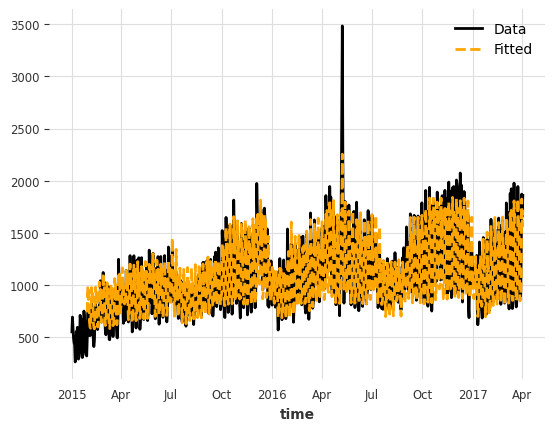

In [74]:
ts_y.plot(label='Data')
fittedvals.plot(label='Fitted', linestyle='--', c='orange')

Let's check both MAPE and sMAPE (since we're using lagged features, there are fewer fitted values than the number of original values):

In [75]:
mape(ts_y.values()[28:], fittedvals.values()), smape(ts_y.values()[28:], fittedvals.values())

(9.573032245612502, 9.470200745393461)

We may also retrieve the feature importances since it's a tree-based model:

In [76]:
model2.lagged_feature_names

['sold_target_lag-28',
 'sold_target_lag-7',
 'sold_target_lag-1',
 'holidays_futcov_lag0',
 'month_futcov_lag0',
 'dayofweek_futcov_lag0',
 'weekofyear_futcov_lag0']

In [77]:
dict(zip(model2.lagged_feature_names, model2.model.feature_importances_))

{'sold_target_lag-28': 0.026272741033558866,
 'sold_target_lag-7': 0.1629649136258618,
 'sold_target_lag-1': 0.2721949415275017,
 'holidays_futcov_lag0': 0.003375083770125017,
 'month_futcov_lag0': 0.006659282925959764,
 'dayofweek_futcov_lag0': 0.5125722051842785,
 'weekofyear_futcov_lag0': 0.01596083193271439}

Check the most important features. Do they make sense, intuitively speaking?

Now, use the model's `predict()` method to make a forecast for 28 days in the future.

In [78]:
pred2 = model2.predict(28)

<Axes: xlabel='time'>

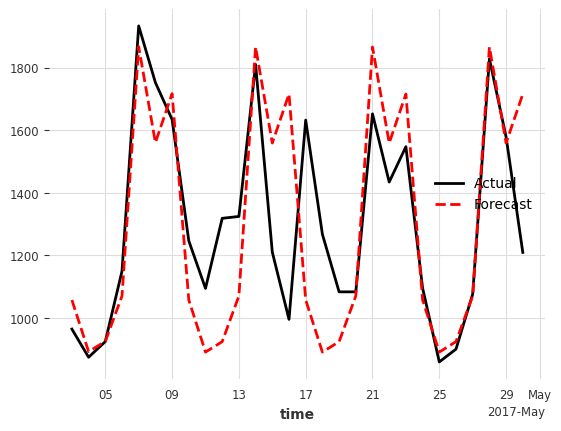

In [79]:
TimeSeries.from_series(test['sold']).plot(label='Actual')
pred2.plot(label='Forecast', c='r', linestyle='--')

# Part #4

### Backtesting

We can also backtest, that is, cross-validate on a variety of rolling windows, with or without retraining using DARTS' `backtest()` method.

It requires the time series and future covariates, just like the `fit()` method, but it also requires a few other arguments that drive the splitting behavior (`start`, `forecast_horizon`, `stride`, `train_length`) and, if you'd like to inspect the metrics after every step, the `reduction` argument should be set to `None`.

We may retrain the model every week (`stride=7`) to make predictions for the following week or month (`forecast_horizon` equals 7 or 28), using 750 data points (`train_length`) to begin with.

In [ ]:
res7 = model2.backtest(ts_y, future_covariates=future_cov,
                       start=None, forecast_horizon=7, stride=7, train_length=750, reduction=None)
res28 = model2.backtest(ts_y, future_covariates=future_cov,
                        start=None, forecast_horizon=28, stride=7, train_length=750, reduction=None)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


In [ ]:
print(res7)

[ 9.89248388  7.10255142  6.48551352  8.33059638  7.96609822  9.38031235
  8.73202442 10.97836758  6.66429675  5.3936521 ]


In [ ]:
print(res28)

[7.28120873 6.23585594 5.96423722 7.49350258 8.27419332 9.78734995
 9.90325525]


# BONUS

### TBATS

In [ ]:
from tbats import TBATS

if __name__ == '__main__':
    estimator = TBATS(seasonal_periods=[7, 365.25], n_jobs=1)

In [ ]:
# Fit model
fitted_model = estimator.fit(train['sold'])

# Summarize fitted model
print(fitted_model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [3 7]
ARMA errors (p, q): (2, 1)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 0.052322
Seasonal Parameters (Gamma): [ 1.78382711e-05  1.04100176e-05 -4.46165346e-06 -2.25811434e-05]
AR coefficients [-4.46165346e-06 -2.25811434e-05]
MA coefficients [0.43149351]
Seed vector [ 6.39994385e+00 -2.96876778e-02  2.00320769e-02 -8.93355786e-02
  2.61366450e-01  2.43214179e-02  6.54603341e-02 -3.16056683e-02
 -6.21205479e-02 -1.60642004e-02 -6.66100977e-03 -4.04745271e-02
  4.56507336e-03 -2.48380468e-02  2.04884294e-02 -1.18826002e-01
 -1.72558867e-02 -5.00516405e-02 -2.92847333e-02 -3.34104256e-02
 -3.90186983e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]

AIC 13650.458084


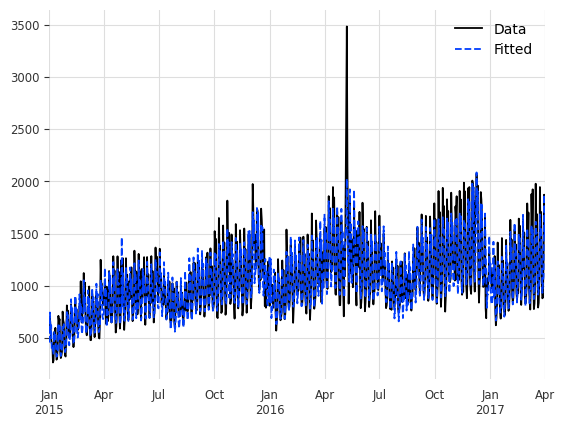

In [ ]:
ax = train['sold'].plot(label='Data')
pred = pd.Series(fitted_model.y_hat, index=train['sold'].index)
ax.plot(pred, label='Fitted', linestyle='--')
plt.legend()

In [ ]:
mape(train['sold'], pred), smape(train['sold'], pred)

(9.583909797219183, 9.618332518329302)

In [ ]:
# Forecast 28 steps ahead
fcast = fitted_model.forecast(steps=28)
fcast

array([1244.97447072, 1029.61445205, 1098.23953261, 1217.14650961,
       1844.05922651, 1531.22958269, 1680.81011346, 1226.77528771,
       1045.5280562 , 1112.7578798 , 1230.75351538, 1861.30884959,
       1543.10910418, 1691.57010689, 1233.26507096, 1050.15362309,
       1116.986005  , 1234.94811483, 1867.33330407, 1548.15244669,
       1697.46087065, 1238.01948493, 1054.73198852, 1122.53410943,
       1241.92083864, 1879.21883942, 1559.12981714, 1710.68456265])

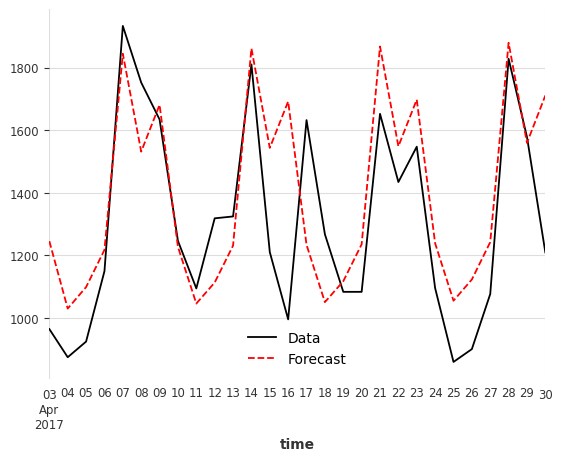

In [ ]:
ax = test['sold'].plot(label='Data')
ax.plot(pd.Series(fcast, index=test['sold'].index), label='Forecast', linestyle='--', c='r')
plt.legend()